# Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch.
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое -- месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Аналогично языковой модели с отбора, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [2]:
%run hw_framework.ipynb

CPU times: user 491 ms, sys: 119 µs, total: 491 ms
Wall time: 267 ms
CPU times: user 45.1 ms, sys: 0 ns, total: 45.1 ms
Wall time: 22.4 ms


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [3]:
def SGD(params, gradients, lr=1e-3):    
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [4]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_modules`.

# Линейная регрессия

In [5]:
n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
Y = np.dot(X, true_w).reshape(n)# + np.random.randn()/5

print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 0.0


### Модель

In [6]:
model = Sequential(
    Linear(10, 3),
    ReLU(),
    Linear(3, 1)
)

criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [7]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

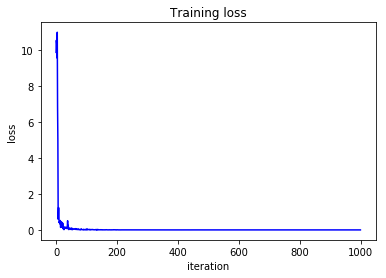

In [8]:
history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        y_true = y_true.reshape(batch_size, -1)
        loss = criterion.forward(y_pred, y_true)
        
#         print(y_pred, y_true)
#         print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])        
        history.append(loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

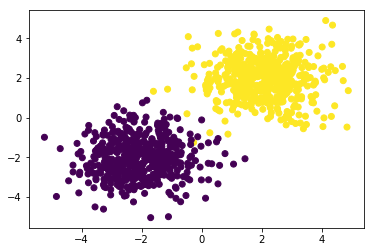

In [9]:
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель


Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [10]:
model = Sequential(
    Linear(2, 2),
    ReLU(),
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [11]:
epochs = 50
batch_size = 8
learning_rate = 1e-2

In [12]:
def accuracy(y_pred, y_true):
#     print(y_pred)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
#     print(y_pred, y_true)
    return (y_pred == y_true).sum() / len(y_true)

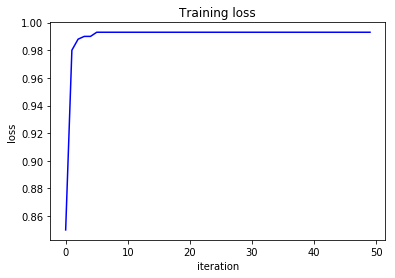

In [13]:
history = []

for i in range(epochs):
    lst = []
    pr = False
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        if pr:
            print(y_pred)
            print(y_true)
            print()
            pr = False
        lst.append(accuracy(y_pred, y_true))
        loss = criterion.forward(y_pred, y_true)
#         print(loss.mean())
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
#         history.append(accuracy(y_pred, y_true))
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
    learning_rate *= 0.99
    learning_rate = max(learning_rate, 1e-5)
    history.append(np.array(lst).sum() / len(lst))
        

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень инфорамативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# Теперь сами

In [14]:
import os
import mnist

# mnist.init()

X_train, y_train, X_test, y_test = mnist.load()

Переведите лейблы в one-hot.

In [15]:
def process(y):
    ny = np.zeros((y.shape[0], 10))
    for a, b in enumerate(y):
        ny[a][b] = 1
    return ny
y_train = process(y_train)
y_test = process(y_test)

In [16]:
y_train[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [17]:
X_train.shape

(60000, 784)

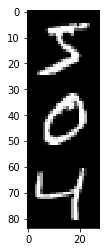

In [18]:
import matplotlib.pyplot as plt

plt.gray()
plt.imshow(X_train[:3].reshape(-1, 28))
plt.show()

Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* Поиграйтесь с архитектурами
* Поиграйтесь с learning rate и batch_size
* Сделайте learning rate decay
* Сделайте data augmentation

In [64]:
%run hw_framework.ipynb

CPU times: user 473 ms, sys: 0 ns, total: 473 ms
Wall time: 240 ms
CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 15.5 ms


In [65]:
model = Sequential(
    Linear(784, 256),
    LeakyReLU(),
    Linear(256, 128),
    LeakyReLU(),
    Linear(128, 32),
    LeakyReLU(),
    Linear(32, 10),
    Sigmoid(),
    SoftMax()
)

criterion =  CrossEntropy()

In [66]:
epochs = 40
batch_size = 20
learning_rate = 1e-2

In [67]:
def accuracy(y_pred, y_true):
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    return (y_pred == y_true).sum() / len(y_true)

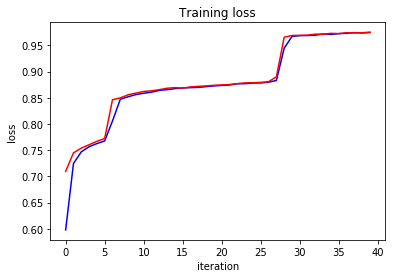

In [68]:
history = []
an_history = []

for i in range(epochs):
    lst = []
    pr = False
    cnt = 0
    for x, y_true in loader(X_test, y_test, batch_size):
        cnt += 1
        y_pred = model.forward(x)
        if pr:
            print(y_pred)
            print(y_true)
            print()
            pr = False
        lst.append(accuracy(y_pred, y_true))
        loss = criterion.forward(y_pred, y_true)
#         print(loss.mean())
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
#         history.append(accuracy(y_pred, y_true))
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
    learning_rate *= 0.9999
    learning_rate = max(learning_rate, 1e-5)
    y_pred = model.forward(X_test)
    an_history.append(accuracy(y_pred, y_test))
    history.append(np.array(lst).sum() / len(lst))
        

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.plot(an_history, 'r')
plt.show()

In [69]:
y_pred = model.forward(X_test)
accuracy(y_pred, y_test)

0.9749